### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

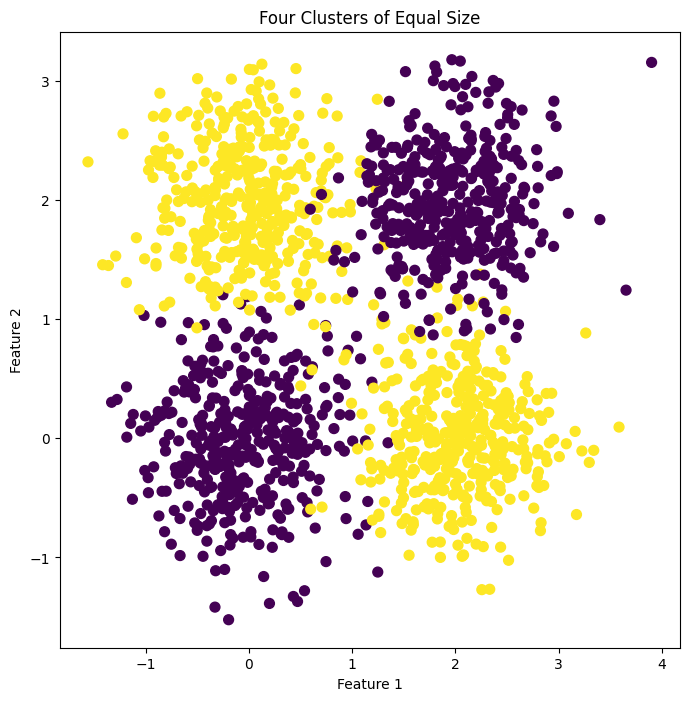

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [8]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


### Regular training

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 60.80it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 59.46it/s, v_num=14]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v13.ckpt



Best model from Phase 1 saved to: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v13.ckpt

--- Testing model from Phase 1 checkpoint: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v13.ckpt ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.4458
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 95.51it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7087163925170898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on 

### Undersampling ROC curve

In [10]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---

# 1. Get original class counts from your train_dataset

try:
    original_labels = np.array(train_data.targets).flatten()
except AttributeError:
    original_labels = train_data[:, -1]

original_counts = Counter(original_labels)
num_pos_original = original_counts.get(1, 0)  
num_neg_original = original_counts.get(0, 0)  
print(f"Original class counts: {num_pos_original} positives, {num_neg_original} negatives")

# The pivot point for your function's logic
orig_sample_ratio = num_pos_original / num_neg_original 

# 2. Define how many steps for each regime
N_POINTS_PER_REGIME = 25  # You can change this

# 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
# This will test scenarios from extreme negative-class dominance up to the original balance.
print(f"Generating ratios for Regime 1 (target ratio < {orig_sample_ratio})...")
ratios_regime1 = np.geomspace(
    start=1/num_neg_original,                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
    stop=orig_sample_ratio,         # Go up to the original ratio
    num=N_POINTS_PER_REGIME,
    endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
)

# 4. Generate ratios for Regime 2 (from the pivot up to 3494)
# This will test scenarios from the original balance up to extreme positive-class dominance.
print(f"Generating ratios for Regime 2 (target ratio > {orig_sample_ratio})...")
ratios_regime2 = np.geomspace(
    start=orig_sample_ratio, # Start just above the pivot
    stop=num_pos_original,                      # Your specified upper limit
    num=N_POINTS_PER_REGIME
)

# 5. Combine, sort, and create the final list for the loop
#    We also add the original ratio to ensure we have a baseline run.
all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
print("First few ratios:", np.round(all_ratios[:5], 3))
print("Last few ratios:", np.round(all_ratios[-5:], 2))

Original class counts: 500 positives, 500 negatives
Generating ratios for Regime 1 (target ratio < 1.0)...
Generating ratios for Regime 2 (target ratio > 1.0)...

Generated 51 unique sample ratios to test.
First few ratios: [0.002 0.003 0.003 0.004 0.005]
Last few ratios: [177.48 229.93 297.89 385.93 500.  ]


In [11]:
import numpy as np
def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    try:
        labels = np.array(train_dataset.targets).flatten()
    except AttributeError:
        labels = train_dataset[:, -1]

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # Create a subset of the original dataset with the sampled indices
    return train_dataset[final_indices]

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, sample_ratio in enumerate(all_ratios):
        # 1. Instantiate the LightningModule
        model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{sample_ratio}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.0

--- Starting Fold 1/4 ---


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.48it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.53it/s, v_num=3]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v12.ckpt


--- Fold 1 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 473.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.4029
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.712344765663147
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.70it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.85it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 491.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5817
AUC: 0.5069
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6949650645256042
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 160.53it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.21it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v12.ckpt


--- Fold 1 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5402
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013395428657532
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.42it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.38it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v12.ckpt


--- Fold 1 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 452.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.5925
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.666667103767395
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.94it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.74it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v12.ckpt


--- Fold 1 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 498.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.6835
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6707766652107239
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.91it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.23it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3567
AUC: 0.4895
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6796742081642151
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.35it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v12.ckpt


--- Fold 1 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 472.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.7090
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6819143891334534
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 159.51it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.76it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 454.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3300
AUC: 0.5365
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6864996552467346
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.52it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.01it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 465.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6067
AUC: 0.6979
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6569919586181641
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.49it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.59it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5473
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7427214980125427
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.88it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.83it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.8052
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6660696864128113
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.85it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.84it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v12.ckpt



--- Fold 1 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 465.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.7687
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6651703119277954
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.98it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.73it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.5641
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873722076416016
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.66it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.54it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 464.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4567
AUC: 0.5352
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6926925182342529
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.30it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.60it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 462.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2925
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7639404535293579
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.55it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.33it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7450
AUC: 0.7726
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6568688750267029
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.68it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.61it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5783
AUC: 0.9487
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6632339954376221
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.54it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.94it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.5248
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6659722924232483
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 160.03it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.20it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.5618
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6749290227890015
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.83it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.81it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 483.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5867
AUC: 0.7173
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6673981547355652
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.38it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.62it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 462.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.4159
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7151995897293091
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.31it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.63it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.5461
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686808168888092
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.62it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.03it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5850
AUC: 0.5320
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7444552779197693
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.22it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.35it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.5327
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6950144171714783
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.61it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.02it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4017
AUC: 0.5406
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6513901948928833
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.90it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.91it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.6537
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6723749041557312
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.39it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.08it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5196
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7212700247764587
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.10it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.49it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5283
AUC: 0.6862
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6753499507904053
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.13it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.38it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 457.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7000
AUC: 0.6525
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6610915064811707
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.46it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.75it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5733
AUC: 0.5756
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6985936760902405
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.14it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.62it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5317
AUC: 0.4665
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7121920585632324
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.81it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.84it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.4945
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7072127461433411
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.68it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.26it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.6855
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6790302395820618
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.55it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.95it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5667
AUC: 0.5370
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6932845711708069
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.75it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5783
AUC: 0.7780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6758815050125122
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.17it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.08it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5339
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7327189445495605
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.10it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.94it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.7953
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6675158739089966
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.76it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.6577
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6627289056777954
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.48it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.84it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.6427
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6546750664710999
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.20it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.51it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.6843
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6632068753242493
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.76it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.06it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.5127
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7044653296470642
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.28it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.31it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.5512
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6817393898963928
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.75it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.57it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.5546
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6909093856811523
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.82it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.84it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.3511
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7298796772956848
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.01it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.23it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 453.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.4679
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6937429308891296
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.30it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.68it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5150
AUC: 0.5881
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6709150075912476
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.51it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.56it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5250
AUC: 0.6371
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6618966460227966
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.97it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.57it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 454.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3750
AUC: 0.2697
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.715285062789917
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.74it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.93it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5890
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6913169622421265
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.59it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.31it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v11.ckpt



--- Fold 1 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4333
AUC: 0.5029
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6963056325912476
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.72it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.49it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v9.ckpt



--- Fold 1 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v9.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v9.ckpt to continue...

--- Testing model after Fold 1 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.3893
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7378576397895813
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.58it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.29it/s, v_num=3]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6867
AUC: 0.7228
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6212562322616577
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.10it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.49it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3167
AUC: 0.4938
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7573381662368774
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.04it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.92it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.4794
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7045194506645203
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.96it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.45it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5413
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6922467947006226
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.26it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.80it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 434.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6883
AUC: 0.5204
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6995009779930115
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.15it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.26it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3950
AUC: 0.3516
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.39it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7057951092720032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.80it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.72it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5350
AUC: 0.6778
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6814128160476685
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.84it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.6093
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866547465324402
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.68it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.86it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5733
AUC: 0.7282
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6353501677513123
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.01it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.42it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5550
AUC: 0.6398
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7044146656990051
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.48it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.14it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3867
AUC: 0.4601
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 224.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203764915466309
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.55it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.13it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4217
AUC: 0.5519
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6967482566833496
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.95it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.76it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.4432
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7139217853546143
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.11it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.41it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4150
AUC: 0.5556
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6973167657852173
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.62it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.40it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6533
AUC: 0.4821
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6913159489631653
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.83it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.98it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.8562
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.679236888885498
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.96it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.43it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6067
AUC: 0.7017
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6884464025497437
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.92it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.69it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7290
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6774303913116455
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.54it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.01it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.6213
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6786463856697083
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.69it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.30it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.5338
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6813262701034546
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.42it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.20it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4937
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.718545138835907
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.98it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.97it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.4692
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.697269082069397
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.32it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.83it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5783
AUC: 0.6534
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6813991069793701
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.26it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.5403
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6962323188781738
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.83it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.46it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3850
AUC: 0.4207
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7394303679466248
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.66it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.35it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.4611
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6875545382499695
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.23it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.89it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.7241
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6735825538635254
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.75it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.48it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 462.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.6977
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6691351532936096
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.50it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.96it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.4864
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7140023708343506
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.93it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.23it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5550
AUC: 0.5581
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 247.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6945677399635315
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.49it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.14it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2983
AUC: 0.4268
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7236121296882629
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.42it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.47it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 478.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.6908
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6611894965171814
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.10it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.83it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5232
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6967521905899048
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.58it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.93it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.5382
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863762140274048
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.50it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.02it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.6134
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6858988404273987
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.89it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.51it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.3123
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7403635382652283
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.37it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.46it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.6581
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6779138445854187
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.23it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.82it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6333
AUC: 0.4400
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7025323510169983
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.01it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 451.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4467
AUC: 0.5289
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6817494630813599
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.50it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.5380
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941640377044678
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.19it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.58it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4333
AUC: 0.4947
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7248398065567017
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.35it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.57it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.7135
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6671951413154602
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.61it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.63it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.6014
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6829811334609985
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.85it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.08it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4217
AUC: 0.4735
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693039059638977
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.84it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.65it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6633
AUC: 0.7070
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6580223441123962
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.00it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.63it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4217
AUC: 0.4743
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7278541922569275
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.35it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.26it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.4142
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7138691544532776
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.02it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.95it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4417
AUC: 0.5410
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6839603185653687
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.10it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.47it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3733
AUC: 0.2294
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7350099682807922
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.19it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v11.ckpt



--- Fold 2 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5959
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7033748626708984
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.05it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.37it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v9.ckpt



--- Fold 2 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v9.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v9.ckpt to continue...

--- Testing model after Fold 2 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.6764
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6726974248886108
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 3/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.05it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.93it/s, v_num=3]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.4967
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7092308402061462
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.51it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.53it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.4804
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7072263360023499
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.45it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.33it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 503.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.6632
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6833350658416748
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.05it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.39it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 458.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.5807
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6807776093482971
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.43it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.33it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6550
AUC: 0.6283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6786916255950928
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.90it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.96it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4750
AUC: 0.5899
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7105444073677063
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.68it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.4970
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.711592435836792
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.93it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.76it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5667
AUC: 0.4982
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6962238550186157
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.42it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.27it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 476.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.5665
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881832480430603
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.96it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.82it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6067
AUC: 0.5102
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815155148506165
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.72it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 439.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7111127972602844
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.27it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.24it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5517
AUC: 0.7810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6522360444068909
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.44it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.13it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6917
AUC: 0.6116
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6666489243507385
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.12it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.65it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3467
AUC: 0.4819
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.05it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6948659420013428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.76it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.53it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4483
AUC: 0.4970
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6991055607795715
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.08it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.21it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6783
AUC: 0.5645
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6625813245773315
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.92it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.36it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4859
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6986459493637085
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.41it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.63it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5974
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6801974773406982
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.51it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.34it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4033
AUC: 0.5299
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6868530511856079
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.57it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.77it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.5436
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7008050680160522
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.60it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.94it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.5711
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6889331340789795
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.10it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.68it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 466.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.6720
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6596952080726624
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.17it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.65it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4224
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7300063967704773
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.42it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.10it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.4769
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6983836889266968
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.30it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.50it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.9106
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6661320328712463
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.93it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.95it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4467
AUC: 0.5439
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6808727383613586
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.99it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.95it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6945289969444275
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.09it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.59it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.5631
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7027742266654968
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.56it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.19it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5640
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912007927894592
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.84it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.32it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.5334
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7016677260398865
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.39it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4850
AUC: 0.4726
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.74it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7154335975646973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.93it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.67it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4083
AUC: 0.4574
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6946083307266235
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.25it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.38it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.5588
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879065036773682
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.26it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.43it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6550
AUC: 0.7341
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815692782402039
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.33it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.61it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.3816
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7600207924842834
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.95it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.94it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3383
AUC: 0.5098
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7103558778762817
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 95.04it/s, v_num=2] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 90.07it/s, v_num=2]
--- Fold 3 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Testing model after Fold 3 Stage 37 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v11.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3250
AUC: 0.4890
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6952546834945679
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.43it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.13it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7554
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6722822785377502
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.50it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.07it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 456.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.4880
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6966102719306946
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.36it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.45it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3533
AUC: 0.5143
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066455483436584
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.75it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.27it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5121
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 246.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7430599331855774
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.30it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.48it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.5401
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7112021446228027
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.14it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.61it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.4159
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7259891629219055
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.26it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.20it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 481.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6383
AUC: 0.5626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879024505615234
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.28it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.24it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.6581
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6817250847816467
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.55it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.35it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5517
AUC: 0.6591
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6626949906349182
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.53it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.99it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.3680
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.734210729598999
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.34it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.71it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3983
AUC: 0.5535
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6982698440551758
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.77it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.22it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.8793
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6592244505882263
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.65it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.21it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v11.ckpt



--- Fold 3 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.6591
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6629682779312134
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.89it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.76it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v9.ckpt



--- Fold 3 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v9.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v9.ckpt to continue...

--- Testing model after Fold 3 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3067
AUC: 0.5289
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6984019875526428
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

--- Starting Fold 4/4 ---
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.32it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.34it/s, v_num=2]


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.6650
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6624362468719482
────────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.60it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.12it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5650
AUC: 0.6555
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6657257676124573
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.88it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.19it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.4790
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6983814239501953
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.15it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.37it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6067
AUC: 0.7220
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.661891758441925
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.15it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.02it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.5433
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7058481574058533
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.25it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.91it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.6617
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6719364523887634
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.32it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.04it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7333
AUC: 0.6566
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6721571087837219
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.30it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.04it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 454.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7033
AUC: 0.6339
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6702377796173096
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.12it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.35it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.5347
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.36it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7110870480537415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.57it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.04it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2950
AUC: 0.4489
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7004105448722839
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.89it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6200
AUC: 0.5885
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6841416954994202
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.76it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.09it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4350
AUC: 0.2878
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7129157781600952
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.81it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.25it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.5398
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7192906737327576
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.35it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.95it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5550
AUC: 0.5605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6892111897468567
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.36it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.40it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5917
AUC: 0.7249
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6726629137992859
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.51it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.47it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.5373
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.680115282535553
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.35it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.27it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.5253
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7067973613739014
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.27it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.36it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.5395
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013169527053833
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.90it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 528.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.8322
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6651883721351624
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.60it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.41it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4700
AUC: 0.5100
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6859279274940491
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.22it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.46it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 478.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.5120
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.729752779006958
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.45it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.01it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.5515
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.694715142250061
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.47it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3583
AUC: 0.5605
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6867092251777649
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.84it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.90it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5316
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7447191476821899
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.41it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.86it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.8948
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.19it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6445654034614563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.80it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.63it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.4585
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7167319059371948
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.25it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.60it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.5475
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6967867016792297
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.92it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.49it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5300
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903393268585205
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.00it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.41it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 460.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6111
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6945509910583496
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.62it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.17it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7805
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.53it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6841402053833008
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.57it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.12it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3717
AUC: 0.4204
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7046311497688293
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.05it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.11it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.7795
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6754288673400879
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.64it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.32it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6700
AUC: 0.5441
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051099538803101
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.06it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.25it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5250
AUC: 0.6776
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6729944348335266
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.25it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.81it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6233
AUC: 0.5154
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7190735340118408
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.01it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.57it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4083
AUC: 0.4914
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003527283668518
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.66it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.18it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6050
AUC: 0.4896
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7439566254615784
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.13it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3617
AUC: 0.5387
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7053723931312561
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.86it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.39it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5317
AUC: 0.5472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.678709089756012
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.51it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.40it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5837
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.685059130191803
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.40it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.21it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.4303
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7535154819488525
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.65it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.30it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 489.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.6763
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6872110962867737
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.88it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.77it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7900
AUC: 0.8872
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6254261136054993
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.75it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.82it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.5039
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6988794803619385
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.70it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.99it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 445.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4167
AUC: 0.3431
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7093756794929504
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.06it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.60it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4733
AUC: 0.4257
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.85it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.708031177520752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.89it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.88it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.6685
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761382222175598
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.89it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.24it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6700
AUC: 0.5910
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6729503870010376
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.08it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.46it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.6824
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815537214279175
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.96it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.35it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v10.ckpt



--- Fold 4 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.5045
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6910738348960876
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.78it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.14it/s, v_num=2]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v8.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v8.ckpt



--- Fold 4 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v8.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v8.ckpt to continue...

--- Testing model after Fold 4 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4271
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7512394785881042
─────────────────────────────────────────────────────────────

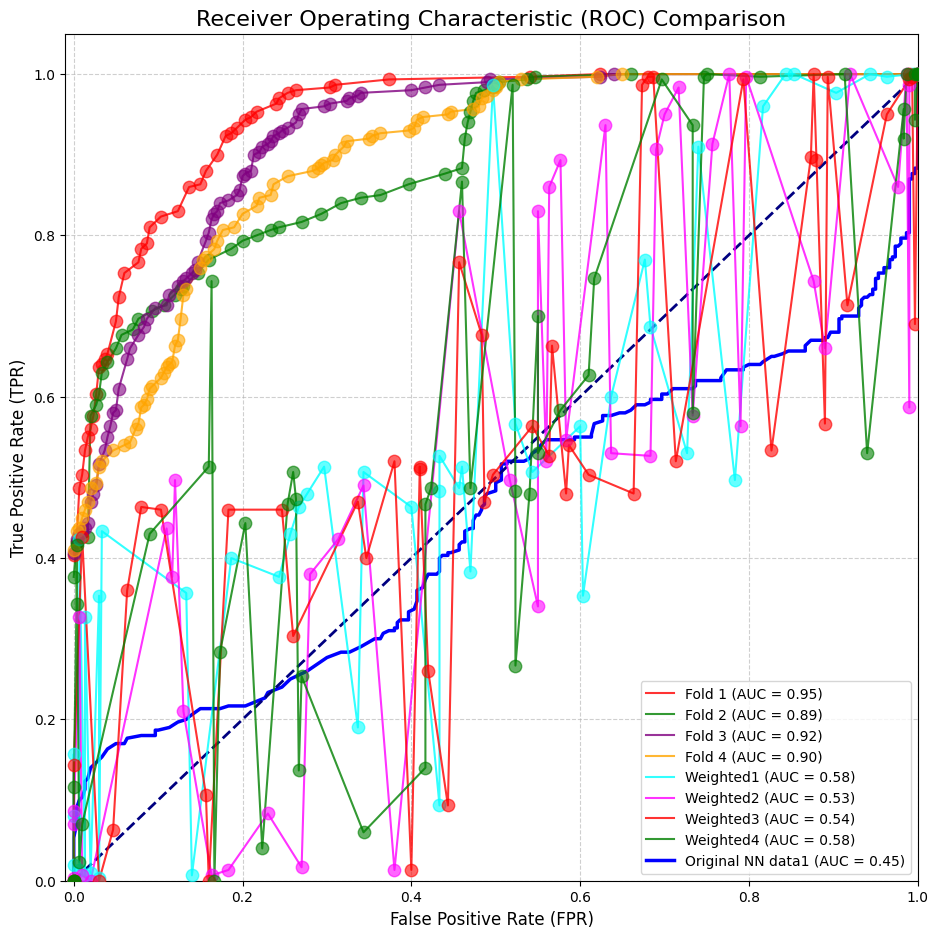

In [13]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [14]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.0067, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.7433, FPR: 0.0200]
Hard Voting -> Resulted in [TPR: 0.4267, FPR: 0.0033]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.8333, FPR: 0.0400]
Hard Voting -> Resulted in [TPR: 0.4767, FPR: 0.0033]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


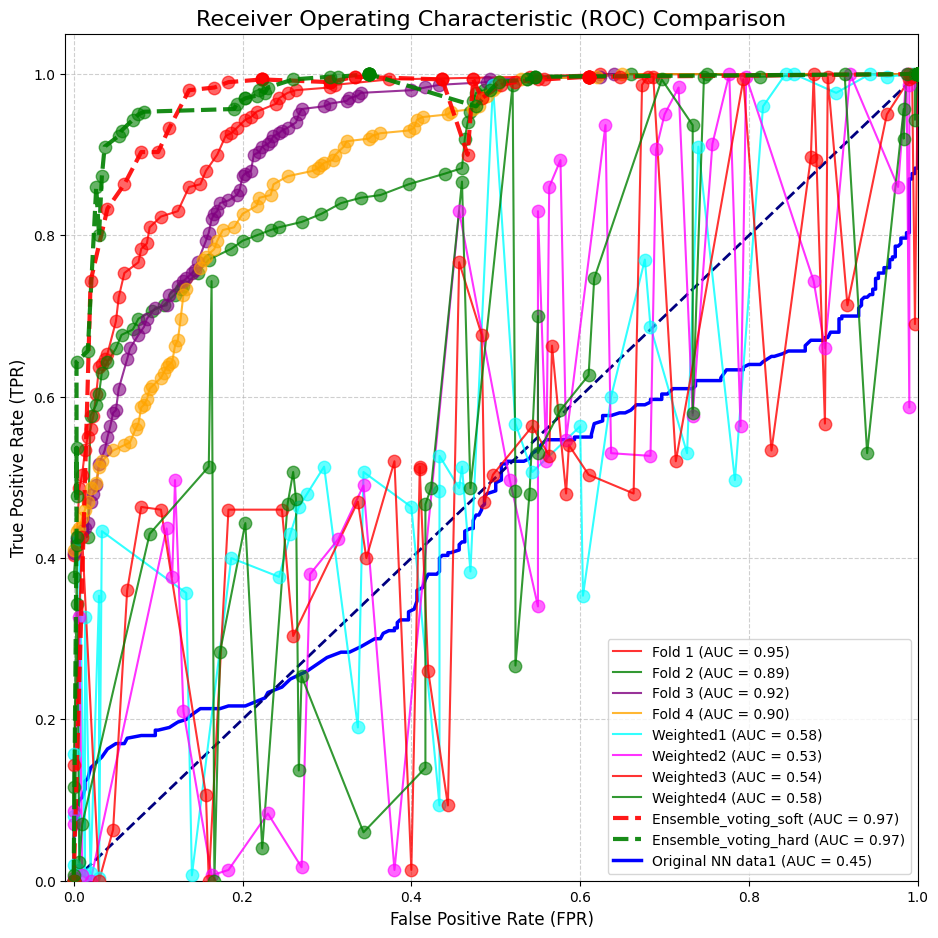

In [15]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)

## Check performances

## Check performance on test1 and test2

In [16]:
def roc_performance_tester(classifier_list, test_loader):

    list_weighted_clfs = []  # Reset the list for final testing
    for i, model_info in enumerate(classifier_list):
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}"),
            precision='16-mixed'
            )

        model = model_info["model"]
        raw_threshold = model_info["threshold"]


        # CORRECTED: Use isinstance() to check if model is a string
        if isinstance(model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{model}'")
            continue

        # Check if the stored threshold is a NumPy number or a PyTorch Tensor
        if isinstance(raw_threshold, (np.number, torch.Tensor)):
            # If it is, we can safely call .item() to extract the Python float
            threshold = raw_threshold.item()
        else:
            # Otherwise, it's already a float or something that can be cast to one
            threshold = float(raw_threshold)
        model.current_test_threshold = threshold  # Set the threshold for this model

        # This code will now only run if 'model' is a PyTorch Lightning module
        # and not a string.
        print(f"--- Testing model {i+1} ---")

        trainer.test(model, dataloaders=test_loader, ckpt_path=None)
        
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)

    # Ensure the curve starts at (0, 0)
    if not list_weighted_clfs or list_weighted_clfs[0]['fpr'] > 0.0:
        list_weighted_clfs.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if list_weighted_clfs[-1]['fpr'] < 1.0 or list_weighted_clfs[-1]['tpr'] < 1.0:
        list_weighted_clfs.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return list_weighted_clfs